In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Load train data
dfTrain = pd.read_csv("train_data.csv", low_memory=False)
dfTrain.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,2,NaN,False,2016-11-11,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,1478822400
1,5,NaN,True,2016-06-06,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1465171200
2,4,NaN,True,2016-03-10,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1457568000
3,5,NaN,True,2016-01-14,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600
4,5,NaN,True,2016-10-20,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1476921600


In [126]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838944 entries, 0 to 838943
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         838944 non-null  int64 
 1   vote            191468 non-null  object
 2   verified        838944 non-null  bool  
 3   reviewTime      838944 non-null  object
 4   reviewerID      838944 non-null  object
 5   asin            838944 non-null  object
 6   style           490613 non-null  object
 7   reviewerName    838717 non-null  object
 8   reviewText      838944 non-null  object
 9   summary         838868 non-null  object
 10  unixReviewTime  838944 non-null  int64 
dtypes: bool(1), int64(2), object(8)
memory usage: 64.8+ MB


In [127]:
dfTrain.describe()

,overall,unixReviewTime
count,838944.000000,8.389440e+05
mean,4.021317,1.483167e+09
std,1.344223,2.229270e+07
min,1.000000,1.451606e+09
25%,3.000000,1.464653e+09
50%,5.000000,1.479254e+09
75%,5.000000,1.499472e+09
max,5.000000,1.538525e+09


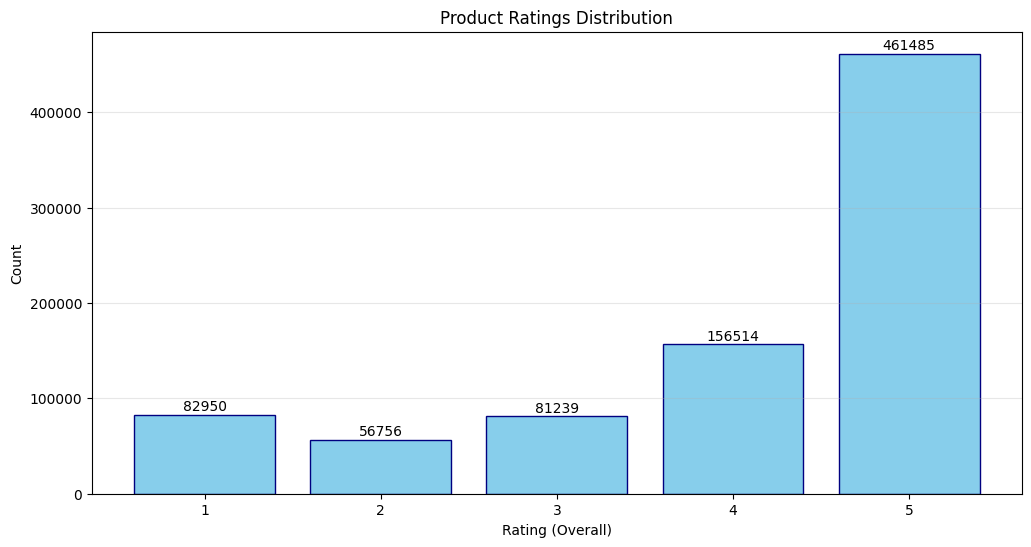

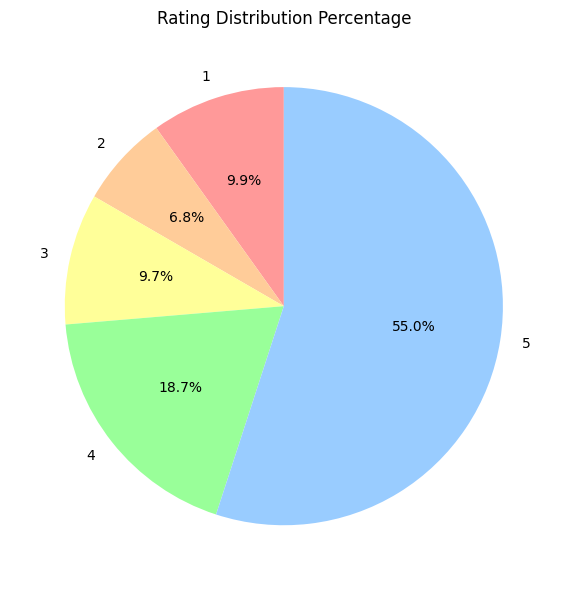

In [128]:
# Bar chart
overall_counts = dfTrain['overall'].value_counts().sort_index()
plt.bar(overall_counts.index, overall_counts.values, color='skyblue', edgecolor='navy')
plt.xlabel('Rating (Overall)')
plt.ylabel('Count')
plt.title('Product Ratings Distribution')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(overall_counts.values):
    plt.text(overall_counts.index[i], v + 1000, str(v), ha='center', va='bottom')
plt.show()

# Pie chart
plt.pie(overall_counts.values, labels=overall_counts.index, autopct='%1.1f%%',
            startangle=90, colors=['#ff9999','#ffcc99','#ffff99','#99ff99','#99ccff'])
plt.title('Rating Distribution Percentage')

plt.tight_layout()
plt.show()


In [129]:
# Create sentiment column based on overall
def categorize_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

dfTrain['sentiment'] = dfTrain['overall'].apply(categorize_sentiment)



In [130]:
# Import required libraries for text processing
import nltk
from nltk.corpus import stopwords
import re

# Download stop words
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# English stop words list
stop_words = set(stopwords.words('english'))

print(f"Number of stop words: {len(stop_words)}")
print("Sample stop words:", list(stop_words)[:20])


Number of stop words: 198
Sample stop words: ['couldn', 'those', 'at', 'what', 'who', 'while', 'ours', 'mustn', "they'd", 'hasn', 'about', "you're", "she'll", 's', "she's", 'how', 'don', 'doesn', 'doing', 'from']


In [131]:
# Text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = str(text).lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stop words
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

In [132]:
# Collect texts for each category
def clean_sentiment_text():
    print("Cleaning texts...")
    texts_by_sentiment = {}
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        # Filter data
        df_sentiment = dfTrain[dfTrain['sentiment'] == sentiment]
        print(f"\n{sentiment}: {len(df_sentiment)} reviews")
        
        # Combine texts
        all_texts = df_sentiment['reviewText'].dropna()
        cleaned_texts = all_texts.apply(clean_text)
        combined_text = ' '.join(cleaned_texts)
        texts_by_sentiment[sentiment] = combined_text
        
        print(f"Word count: {len(combined_text.split())}")
        print("\nReady to create Word Cloud...")
    return texts_by_sentiment



In [133]:
# Plot Word Cloud for each category
def plot_word_cloud(texts_by_sentiment):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    colors = {'Positive': 'Greens', 'Neutral': 'Blues', 'Negative': 'Reds'}
    sentiments_order = ['Positive', 'Neutral', 'Negative']
    
    for idx, sentiment in enumerate(sentiments_order):
        # Create Word Cloud
        wordcloud = WordCloud(
            width=600, 
            height=400,
            background_color='white',
            colormap=colors[sentiment],
            max_words=100,
            relative_scaling=0.5,
            min_font_size=10
        ).generate(texts_by_sentiment[sentiment])
        
        # Plot
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'Word Cloud - {sentiment} Sentiment', fontsize=14, fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


Cleaning texts...

Positive: 617999 reviews
Word count: 34448370

Ready to create Word Cloud...

Neutral: 81239 reviews
Word count: 4884512

Ready to create Word Cloud...

Negative: 139706 reviews
Word count: 7735317

Ready to create Word Cloud...


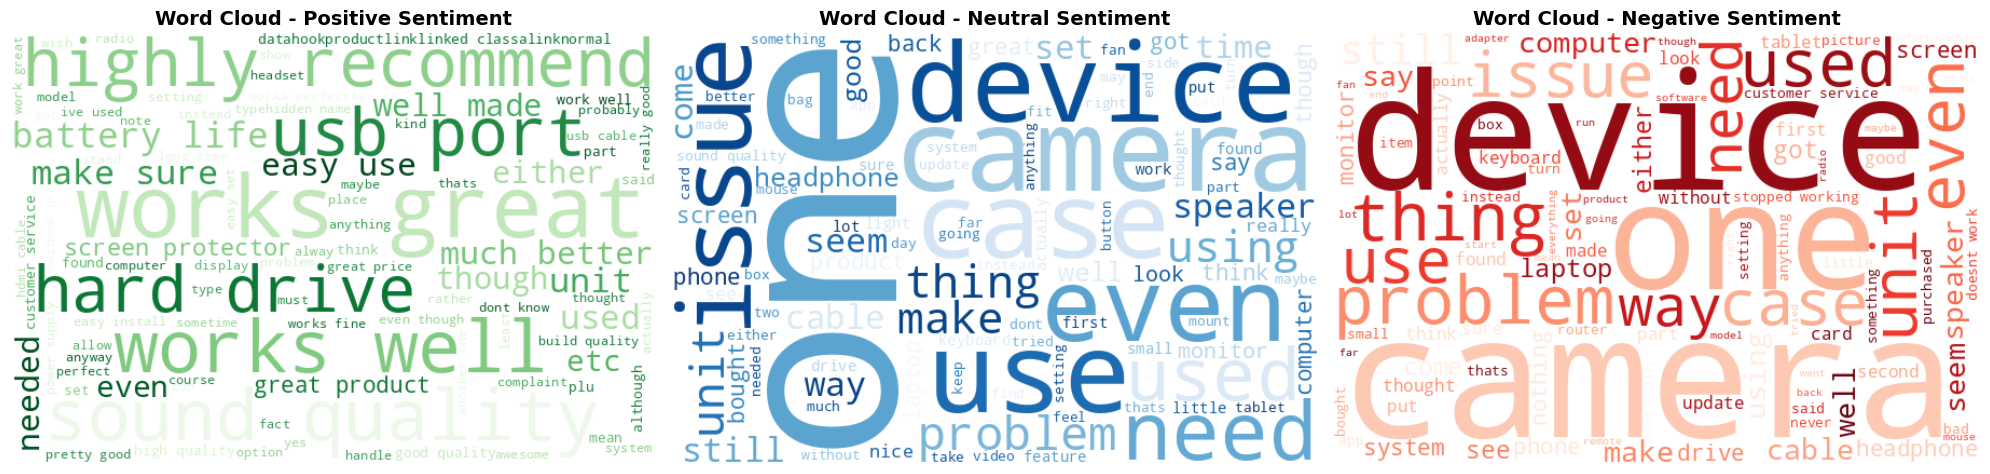

In [134]:
texts_by_sentiment = clean_sentiment_text()
plot_word_cloud(texts_by_sentiment)

Cleaning texts...

Positive: 617999 reviews
Word count: 31525905

Ready to create Word Cloud...

Neutral: 81239 reviews
Word count: 4456041

Ready to create Word Cloud...

Negative: 139706 reviews
Word count: 7056346

Ready to create Word Cloud...


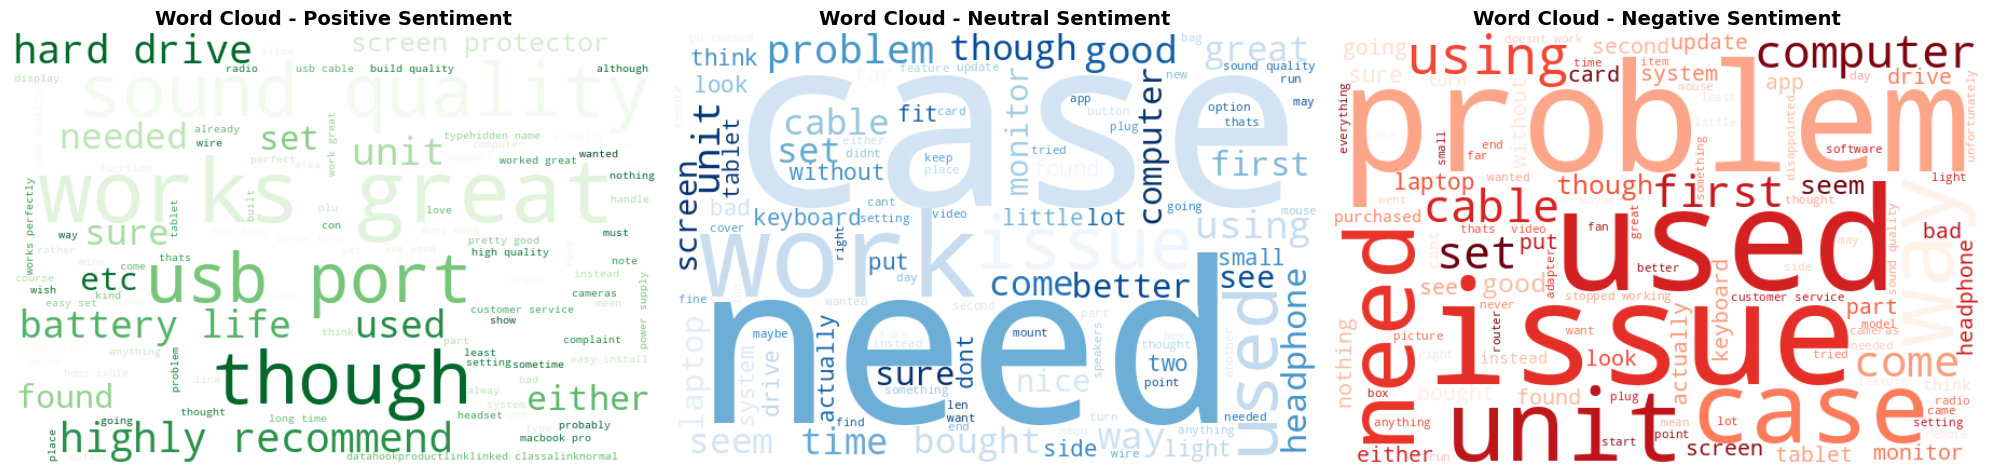

In [135]:
# Add additional words that usually have little information
additional_stops = {'product', 'one', 'use', 'like', 'get', 'got', 'would', 'could', 
                   'also', 'really', 'even', 'made', 'make', 'thing', 'things', 
                   'much', 'well', 'still', 'back', 'say', 'said', 'camera', 'speaker', 'device', 'phone'}
stop_words.update(additional_stops)

texts_by_sentiment = clean_sentiment_text()
plot_word_cloud(texts_by_sentiment)

Top 10 reviewers by helpfulness (highest total votes):
 Rank     Reviewer Name  Total Votes  Review Count
    1      Benson Leung       4572.0            29
    2           Obi Wan       1608.0            29
    3      Chris Winter       1352.0             4
    4          Mayra S.       1342.0            19
    5        VermontGuy       1337.0             7
    6           Michael       1230.0           132
    7     PhotoGraphics       1209.0            68
    8          Nicholas       1188.0            23
    9 NLee the Engineer       1103.0            31
   10           David H       1045.0             5


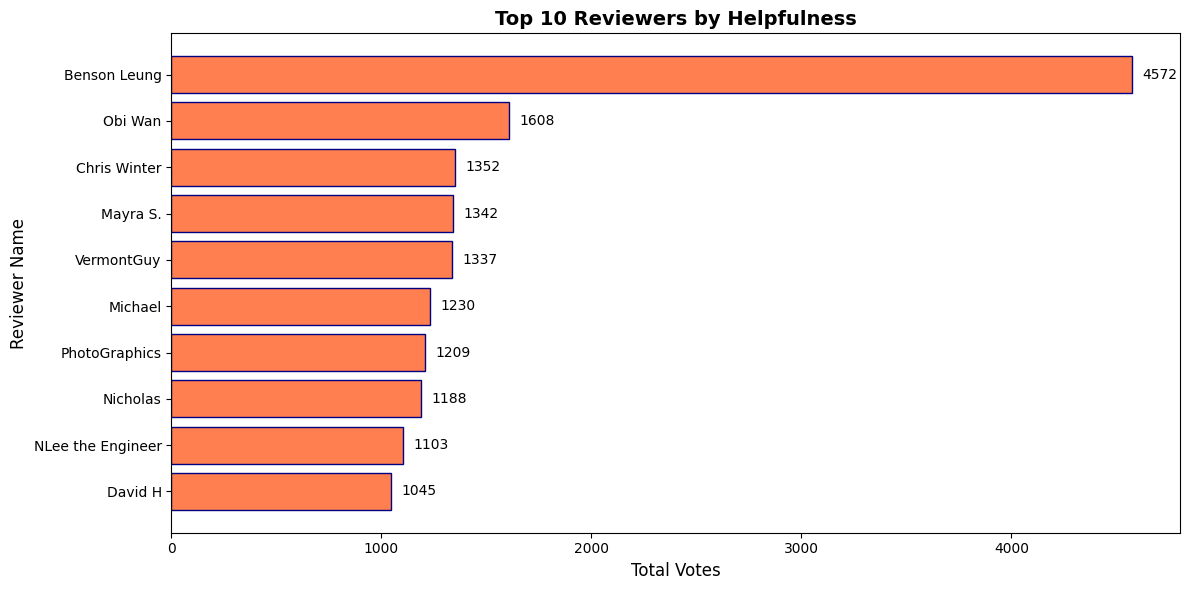

In [136]:
# Convert vote column to numeric
dfTrain['vote'] = pd.to_numeric(dfTrain['vote'], errors='coerce').fillna(0)

# Group by reviewerID and reviewerName and calculate total votes and review count for each person
reviewer_stats = dfTrain.groupby(['reviewerID', 'reviewerName']).agg({
    'vote': 'sum',
    'reviewText': 'count'
}).reset_index()
reviewer_stats.value_counts()

reviewer_stats.columns = ['reviewerID', 'reviewerName', 'total_votes', 'review_count']

# Sort by total votes
top_10_reviewers = reviewer_stats.sort_values('total_votes', ascending=False).head(10)

print("Top 10 reviewers by helpfulness (highest total votes):")
print("="*70)

# Display as table
display_df = top_10_reviewers.copy()
display_df['Rank'] = range(1, 11)
display_df = display_df[['Rank', 'reviewerName', 'total_votes', 'review_count']]
display_df.columns = ['Rank', 'Reviewer Name', 'Total Votes', 'Review Count']

print(display_df.to_string(index=False))

# Plot
plt.barh(range(10), top_10_reviewers['total_votes'].values, color='coral', edgecolor='navy')
plt.yticks(range(10), top_10_reviewers['reviewerName'].values)
plt.xlabel('Total Votes', fontsize=12)
plt.ylabel('Reviewer Name', fontsize=12)
plt.title('Top 10 Reviewers by Helpfulness', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # For better display from top to bottom
for i, v in enumerate(top_10_reviewers['total_votes'].values):
    plt.text(v + 50, i, str(int(v)), va='center')
plt.tight_layout()
plt.show()


In [151]:
# Calculate length of each text
dfTrain['text_length'] = dfTrain['reviewText'].fillna('').apply(len)

# Descriptive statistics of text length
print("Descriptive statistics of text length (character count):")
print(dfTrain['text_length'].describe())
print(f"\nMinimum length: {dfTrain['text_length'].min()}")
print(f"Maximum length: {dfTrain['text_length'].max()}")
print(f"Median: {dfTrain['text_length'].median()}")

# Check percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    value = dfTrain['text_length'].quantile(p/100)
    print(f"{p}%: {value:.0f} characters")


Descriptive statistics of text length (character count):
count    838944.000000
mean        624.687384
std         684.129474
min         200.000000
25%         277.000000
50%         408.000000
75%         697.000000
max       29146.000000
Name: text_length, dtype: float64

Minimum length: 200
Maximum length: 29146
Median: 408.0

Percentiles:
25%: 277 characters
50%: 408 characters
75%: 697 characters
90%: 1217 characters
95%: 1733 characters
99%: 3399 characters


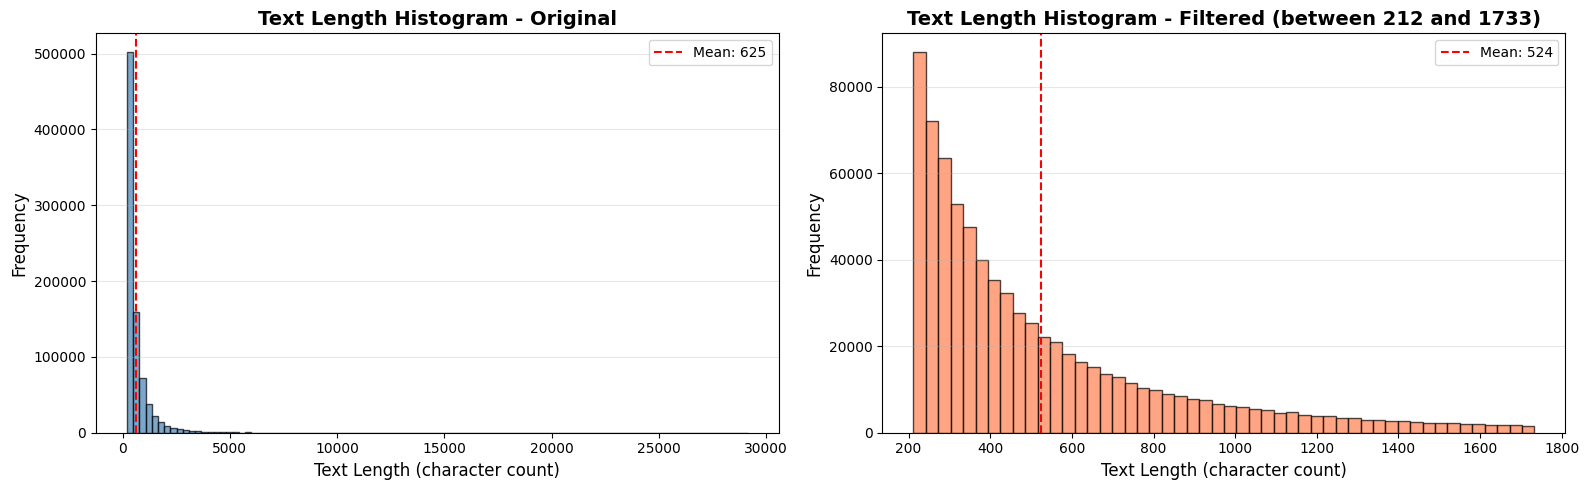


Original sample count: 838944
Filtered sample count: 758149
Data preserved percentage: 90.4%


In [138]:
# Plot histogram - original and filtered
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Complete histogram (original)
axes[0].hist(dfTrain['text_length'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Text Length (character count)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Text Length Histogram - Original', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axvline(dfTrain['text_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {dfTrain["text_length"].mean():.0f}')
axes[0].legend()

# Filtered histogram (remove outliers)
# Filter: only data between 5th and 95th percentile
q5 = dfTrain['text_length'].quantile(0.05)
q95 = dfTrain['text_length'].quantile(0.95)
filtered_data = dfTrain[(dfTrain['text_length'] >= q5) & (dfTrain['text_length'] <= q95)]

axes[1].hist(filtered_data['text_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Text Length (character count)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Text Length Histogram - Filtered (between {q5:.0f} and {q95:.0f})', 
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axvline(filtered_data['text_length'].mean(), color='red', linestyle='--',
                label=f'Mean: {filtered_data["text_length"].mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nOriginal sample count: {len(dfTrain)}")
print(f"Filtered sample count: {len(filtered_data)}")
print(f"Data preserved percentage: {len(filtered_data)/len(dfTrain)*100:.1f}%")


In [139]:
# Load title_brand file to access brand name and product title
dfTitleBrand = pd.read_csv("title_brand.csv")
print(f"title_brand data shape: {dfTitleBrand.shape}")
print(f"Columns: {dfTitleBrand.columns.tolist()}")
dfTitleBrand.head()


title_brand data shape: (786445, 3)
Columns: ['asin', 'title', 'brand']


,asin,title,brand
0,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision
1,0043396828,"Books ""Handbook of Astronomical Image Processi...",33 Books Co.
2,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page
3,0060219602,Hurray for Hattie Rabbit: Story and pictures (...,Visit Amazon's Dick Gackenbach Page
4,0060786817,sex.lies.murder.fame.: A Novel,Visit Amazon's Lolita Files Page


Number of reviews with rating 5: 461485

Top 10 products with most 5-star ratings:
 Rank                  Brand                                                   Product Title  Count of 5-star
    1   Cambridge Soundworks OontZ Angle 3 Enhanced Stereo Edition IPX5 Splashproof Porta...             1163
    2                NETGEAR                       NETGEAR N300 WiFi Range Extender (EX2700)              659
    3                   Roku Roku Streaming Stick (3600R) - HD Streaming Player with Quad...              600
    4               StarTech              StarTech USB 2.0 to SATA IDE Adapter (USB2SATAIDE)              598
    5               Logitech Logitech M570 Wireless Trackball Mouse &ndash; Ergonomic Des...              552
    6                Samsung Samsung 850 EVO 500GB 2.5-Inch SATA III Internal SSD (MZ-75E...              529
    7                   Asus ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up to 3167 Mbps)...              471
    8              VideoSecu VideoSec

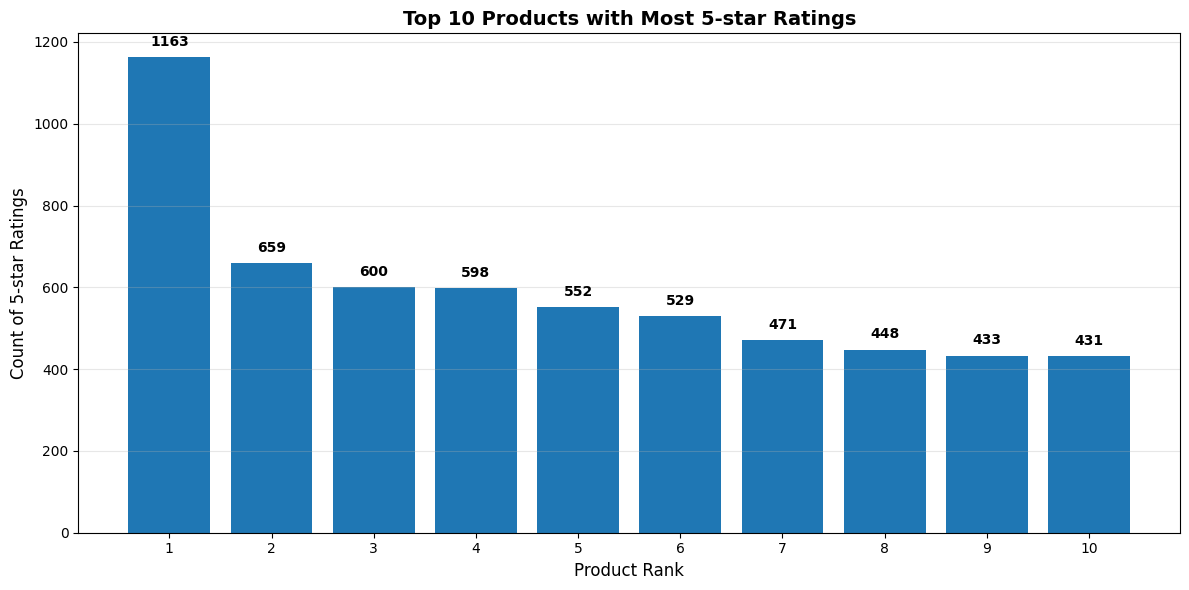

In [140]:
# Filter reviews with rating 5
df_rating_5 = dfTrain[dfTrain['overall'] == 5.0]
print(f"Number of reviews with rating 5: {len(df_rating_5)}")

# Count number of 5-star ratings for each product
product_rating_5_count = df_rating_5.groupby('asin').size().reset_index(name='count_rating_5')

# Sort and select top 10
top_10_products = product_rating_5_count.sort_values('count_rating_5', ascending=False).head(10)

# Merge with title_brand to get brand name and title
top_10_products = top_10_products.merge(dfTitleBrand, on='asin', how='left')

# Display results
print("\nTop 10 products with most 5-star ratings:")
print("="*100)

display_df = top_10_products.copy()
display_df['Rank'] = range(1, 11)
display_df = display_df[['Rank', 'brand', 'title', 'count_rating_5']]
display_df.columns = ['Rank', 'Brand', 'Product Title', 'Count of 5-star']

# Limit title length for better display
display_df['Product Title'] = display_df['Product Title'].apply(
    lambda x: x[:60] + '...' if pd.notna(x) and len(str(x)) > 60 else x
)

print(display_df.to_string(index=False))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(10), top_10_products['count_rating_5'].values)
plt.xticks(range(10), [f"{i+1}" for i in range(10)])
plt.xlabel('Product Rank', fontsize=12)
plt.ylabel('Count of 5-star Ratings', fontsize=12)
plt.title('Top 10 Products with Most 5-star Ratings', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(top_10_products['count_rating_5'].values):
    plt.text(i, v + 20, str(int(v)), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


In [141]:
# Top brands by review count and their average ratings

# Merge train data with title_brand
dfTrain_with_brand = dfTrain.merge(dfTitleBrand[['asin', 'brand']], on='asin', how='left')

# Count number of reviews per brand
brand_review_count = dfTrain_with_brand.groupby('brand').size().reset_index(name='review_count')

# Top 10 brands with most reviews
top_10_brands = brand_review_count.sort_values('review_count', ascending=False).head(10)

print("Top 10 brands with most reviews:")
print(top_10_brands.to_string(index=False))


Top 10 brands with most reviews:
       brand  review_count
    Logitech         17066
     Samsung         15409
AmazonBasics         13213
        Sony         12436
        Asus         11928
       Anker          9860
     TP-LINK          9773
     SanDisk          8400
     Sabrent          7320
     NETGEAR          7085


In [142]:
# Calculate average rating for these 10 brands
top_brands_list = top_10_brands['brand'].tolist()

brand_avg_rating = dfTrain_with_brand[dfTrain_with_brand['brand'].isin(top_brands_list)].groupby('brand').agg({
    'overall': 'mean',
    'reviewText': 'count'
}).reset_index()

brand_avg_rating.columns = ['brand', 'avg_rating', 'review_count']

# Sort by average rating
brand_avg_rating = brand_avg_rating.sort_values('avg_rating', ascending=False)

print("\nTop 10 brands ordered by average rating:")
print("="*70)

display_df = brand_avg_rating.copy()
display_df['Rank'] = range(1, len(display_df) + 1)
display_df = display_df[['Rank', 'brand', 'avg_rating', 'review_count']]
display_df.columns = ['Rank', 'Brand Name', 'Average Rating', 'Review Count']
display_df['Average Rating'] = display_df['Average Rating'].round(2)

print(display_df.to_string(index=False))



Top 10 brands ordered by average rating:
 Rank   Brand Name  Average Rating  Review Count
    1        Anker            4.24          9860
    2 AmazonBasics            4.20         13213
    3      Sabrent            4.03          7320
    4      SanDisk            3.96          8400
    5     Logitech            3.95         17066
    6      Samsung            3.94         15409
    7         Sony            3.94         12436
    8      TP-LINK            3.93          9773
    9         Asus            3.86         11928
   10      NETGEAR            3.84          7085


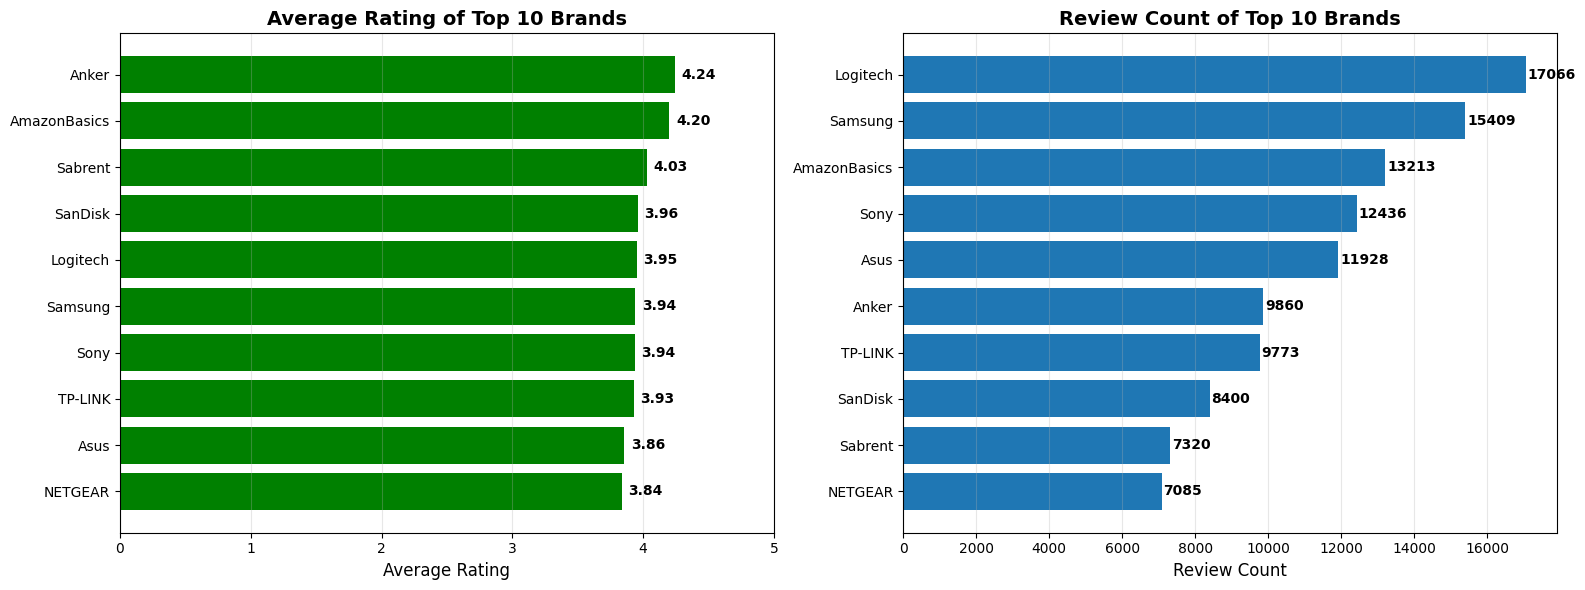

In [150]:
# Plot average rating and review count
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Average rating
axes[0].barh(range(len(brand_avg_rating)), brand_avg_rating['avg_rating'].values, color=['green'])
axes[0].set_yticks(range(len(brand_avg_rating)))
axes[0].set_yticklabels(brand_avg_rating['brand'].values)
axes[0].set_xlabel('Average Rating', fontsize=12)
axes[0].set_title('Average Rating of Top 10 Brands', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 5)
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(brand_avg_rating['avg_rating'].values):
    axes[0].text(v + 0.05, i, f'{v:.2f}', va='center', fontweight='bold')
axes[0].invert_yaxis()

# Chart 2: Review count
brand_by_count = brand_avg_rating.sort_values('review_count', ascending=False)
axes[1].barh(range(len(brand_by_count)), brand_by_count['review_count'].values)
axes[1].set_yticks(range(len(brand_by_count)))
axes[1].set_yticklabels(brand_by_count['brand'].values)
axes[1].set_xlabel('Review Count', fontsize=12)
axes[1].set_title('Review Count of Top 10 Brands', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(brand_by_count['review_count'].values):
    axes[1].text(v + 50, i, str(int(v)), va='center', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
